# **Geomodeling**

In [1]:
import numpy as np
np.random.seed(12345)
import random
random.seed(12345)
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rcParams['image.cmap'] = 'viridis'

In [2]:
from scipy.spatial.distance import pdist, squareform

def variogram_one_lag(X, perm, lag, bin_width):
    """Experimental semi-variogram for one lag"""
    dist_mat = squareform(pdist(X))
    n_points = dist_mat.shape[0]
    list_var = []
    for i in range(n_points):
        for j in range(i + 1, n_points):
            if(dist_mat[i, j] >= (lag - bin_width)) and \
            (dist_mat[i, j] <= (lag + bin_width)):
                list_var.append((perm[i] - perm[j])**2.0)
    return np.sum(list_var) / (2.0 * len(list_var))

def variogram(X, perm, lags, bin_width):
    """Experimental variogram calculation"""
    variogram = []
    for lag in lags:
        variogram.append(variogram_one_lag(X, perm, lag, bin_width))
    return variogram

In [3]:
class Coord3D:
    """This class is used for defining a 3D coordinate"""
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

class Grid3D:
    """This class defines a 3D Grid"""
    def __init__(self, ascii_file_path):
        self.file_path = ascii_file_path
        self.nx = -1
        self.ny = -1
        self.nz = -1
        self.top_coords = None
        self.bot_coords = None
        self.zcorns = None
        self.permx = None
        self.cell_centers = None

    def get_indexed_corner_depths(self, zcorns):
        zcorn_3d = np.empty((self.nx, self.ny, self.nz), dtype=object)
        min_float32 = -np.inf
        for i in range(self.nx):
            for j in range(self.ny):
                for k in range(self.nz):
                    zcorn_3d[i, j, k] = [min_float32, 
                                         min_float32, 
                                         min_float32, 
                                         min_float32, 
                                         min_float32, 
                                         min_float32, 
                                         min_float32, 
                                         min_float32]
        count = 0
        # populate a 3D darray with corner point depths
        for k in range(self.nz):
            for j in range(self.ny):
                for i in range(self.nx):
                    tmp = zcorn_3d[i, j, k]
                    tmp[0] = np.float32(zcorns[count])
                    count = count + 1
                    tmp[1] = np.float32(zcorns[count])
                    count = count + 1
                    zcorn_3d[i, j, k] = tmp
                for i in range(self.nx):
                    tmp = zcorn_3d[i, j, k]
                    tmp[2] = np.float32(zcorns[count])
                    count = count + 1
                    tmp[3] = np.float32(zcorns[count])
                    count = count + 1
                    zcorn_3d[i, j, k] = tmp
            for j in range(self.ny):
                for i in range(self.nx):
                    tmp = zcorn_3d[i, j, k]
                    tmp[4] = np.float32(zcorns[count])
                    count = count + 1
                    tmp[5] = np.float32(zcorns[count])
                    count = count + 1
                    zcorn_3d[i, j, k] = tmp
                for i in range(self.nx):
                    tmp = zcorn_3d[i, j, k]
                    tmp[6] = np.float32(zcorns[count])
                    count = count + 1
                    tmp[7] = np.float32(zcorns[count])
                    count = count + 1
                    zcorn_3d[i, j, k] = tmp
        return zcorn_3d

    def get_indexed_coords(self, coords):
        top_coords = np.empty((self.nx + 1, self.ny + 1), dtype=object)
        bot_coords = np.empty((self.nx + 1, self.ny + 1), dtype=object)
        count = 0
        # populate the indexed 2D numpy.ndarray with horizon coordinates
        for j in range(self.ny + 1):
            for i in range(self.nx + 1):
                top_coords[i, j] = Coord3D(np.float32(coords[count]), 
                                           np.float32(coords[count + 1]), 
                                           np.float32(coords[count + 2]))
                bot_coords[i, j] = Coord3D(np.float32(coords[count + 3]), 
                                           np.float32(coords[count + 4]), 
                                           np.float32(coords[count + 5]))
                count = count + 6
        return top_coords, bot_coords
    
    def get_indexed_grid_props(self, prop_list, dtype=np.float32):
        props = np.empty((self.nx, self.ny, self.nz), dtype=dtype)
        count = 0
        for k in range(self.nz):
            for j in range(self.ny):
                for i in range(self.nx):
                    props[i, j, k] = prop_list[count]
                    count = count + 1            
        return props

    def compute_grid_cell_centers(self):
        centers = np.empty((self.nx, self.ny, self.nz), dtype=object)
        ijks = np.empty((self.nx, self.ny, self.nz), dtype=object)
        for k in range(self.nz):
            for j in range(self.ny):
                for i in range(self.nx):
                    zcorns = self.zcorns[i, j, k]
                    xcorns = [[c.x for c in corns] for corns \
                              in self.top_coords[i:i + 2,j:j + 2]]
                    ycorns = [[c.y for c in corns] for corns \
                              in self.top_coords[i:i + 2,j:j + 2]]
                    x_center = np.mean(xcorns)
                    y_center = np.mean(ycorns)
                    z_center = np.mean(zcorns)
                    centers[i, j, k] = Coord3D(x_center, y_center, z_center)
        self.cell_centers = centers

    def populate_grid(self):
        f = open(self.file_path, 'r')
        line = f.readline()
        while line:
            # Populate top/bottom horizon coordinates
            if 'COORD' in line:
                coords = []
                while line and '/' not in line:
                    line = f.readline()
                    values = line.split()
                    n_values = len(values)
                    for i in range(n_values):
                        coords.append(values[i])
                coords = coords[:-1] # COORD block ends with a "/", skip it
                self.top_coords, self.bot_coords = self.get_indexed_coords(coords)
            # Populate cell cornor point depths
            elif 'ZCORN' in line:
                zcorns = []
                while line and '/' not in line:
                    line = f.readline()
                    values = line.split()
                    n_values = len(values)
                    for i in range(n_values):
                        entry = values[i].split('*')
                        if len(entry) == 2:
                            for j in range(int(entry[0])):
                                zcorns.append(float(entry[1]))
                        elif len(entry) == 1:
                            if entry[0] == '/':
                                pass
                            else:
                                zcorns.append(float(entry[0]))
                self.zcorns = self.get_indexed_corner_depths(zcorns)
            # Populate permx property
            elif 'PERMX' in line:
                perms = []
                while line and '/' not in line:
                    line = f.readline()
                    values = line.split()
                    n_values = len(values)
                    for i in range(n_values):
                        entry = values[i].split('*')
                        if len(entry) == 2:
                            for j in range(int(entry[0])):
                                perms.append(float(entry[1]))
                        elif len(entry) == 1:
                            if entry[0] == '/':
                                pass
                            else:
                                perms.append(float(entry[0]))
                perms = self.get_indexed_grid_props(perms, np.float32)
                self.permx = perms
            # Populate number of cells
            elif 'SPECGRID' in line:
                line = f.readline()
                values = line.split()
                self.nx = int(values[0])
                self.ny = int(values[1])
                self.nz = int(values[2])
            line = f.readline()
        f.close()
        # Compute grid cell centers
        self.compute_grid_cell_centers()

In [4]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [5]:
!unzip data

Archive:  data.zip
  inflating: data/SPE9.GRDECL        


In [6]:
cwd = os.getcwd()
data_path = os.path.join(cwd, 'data')
file_path = os.path.join(data_path, 'SPE9.GRDECL')
# Populate 3D Grid based upon the provided GRDECL file
grid3D = Grid3D(file_path)
grid3D.populate_grid()
centers = grid3D.cell_centers
permx = grid3D.permx

mu_perm = np.mean(permx)
print('Mean: %f' % mu_perm)
std_perm = np.std(permx)
print('Std. Dev.: %f' % std_perm)
var_perm = np.var(permx)
print('Variance: %f' % var_perm)

Mean: 108.082397
Std. Dev.: 375.308472
Variance: 140856.437500


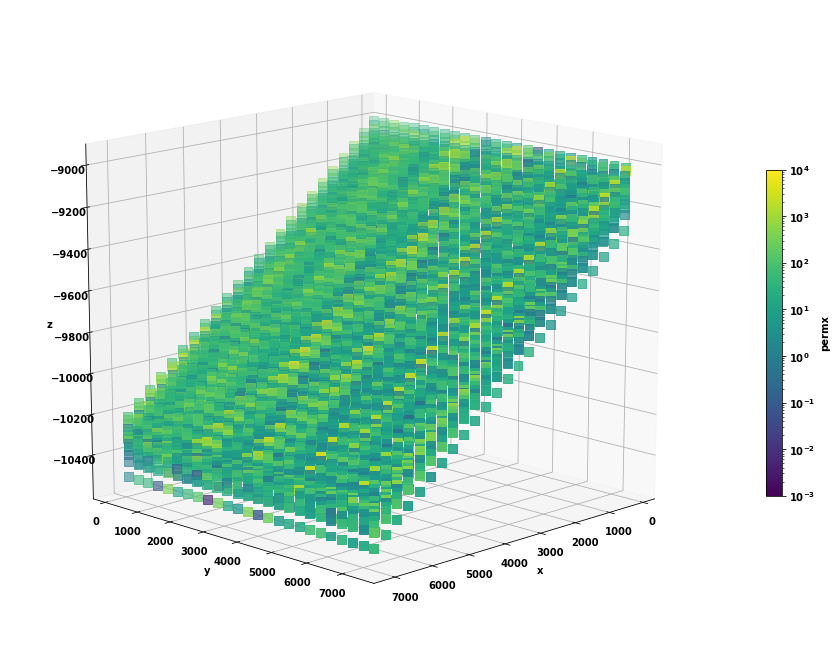

In [7]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter([center.x for center in centers.flatten()], 
               [center.y for center in centers.flatten()], 
               [-center.z for center in centers.flatten()], 
               c=permx.flatten(), marker='s', s=80, 
               norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e4))
ax.set_xlabel('x', weight='bold')
ax.set_ylabel('y', weight='bold')
ax.set_zlabel('z', weight='bold')
ax.view_init(15, 45)
cb = fig.colorbar(p, shrink=0.5)
cb.set_label('permx', weight='bold')
fig.savefig(os.path.join(cwd, 'fig1.png'), dpi=600)

In [8]:
# Calculate experimental variograms
bin_width = 500.
lags = np.arange(0.,7000.,500.)
nx = centers.shape[0]
ny = centers.shape[1]
nz = centers.shape[2]
X = []
y = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            X.append([centers[i, j, k].x, centers[i, j, k].y, centers[i, j, k].z])
            y.append(permx[i, j, k])
exp_var_all = variogram(X, y, lags, bin_width) # Note: This will take a while to finish.

In [9]:
# Define constants for grid definition
n_wells = 26
i_wells = [23, 4, 7, 10, 9, 11, 3, 7, 13, 10, 11, 9, 4, 7, 10, 12, 14, 10, 11, 4, 7, 10, 14, 11, 9, 16]
j_wells = [24, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
well_names = ["INJE1", "PRODU2", "PRODU3", "PRODU4", "PRODU5", "PRODU6", "PRODU7", "PRODU8", "PRODU9", 
              "PRODU10", "PRODU11", "PRODU12", "PRODU13", "PRODU14", "PRODU15", "PRODU16", "PRODU17", 
              "PRODU18", "PRODU19", "PRODU20", "PRODU21", "PRODU22", "PRODU23", "PRODU24", "PRODU25", "PRODU26"]

def export_wells_as_features(centers, prop, iwells, jwells):
    X = []
    y = []
    I = []
    for w in range(n_wells):
        for i in range(nx):
            for j in range(ny):
                if i == iwells[w] and j == jwells[w]:
                    for k in range(nz):
                        X.append([centers[i, j, k].x, centers[i, j, k].y, centers[i, j, k].z])
                        y.append(prop[i, j, k])
    return X, y

X, y = export_wells_as_features(centers, permx, i_wells, j_wells)
mu_y = np.mean(y)
print('Mean: %f' % mu_y)
std_y = np.std(y)
print('Std. Dev.: %f' % std_y)
var_y = np.var(y)
print('Variance: %f' % var_y)

Mean: 116.466026
Std. Dev.: 507.235168
Variance: 257287.531250


In [10]:
exp_var_wells = variogram(X, y, lags, bin_width)

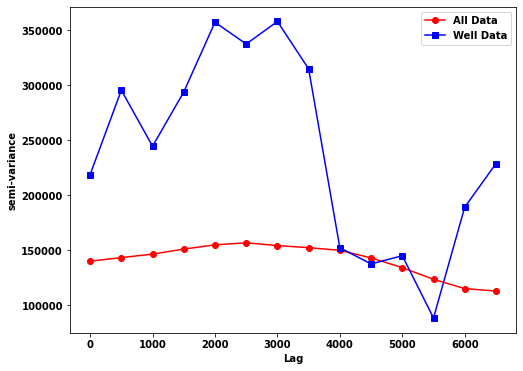

In [11]:
fig = plt.figure(figsize=(8, 6))
plt.plot(lags, exp_var_all, marker='o', c='r', label='All Data')
plt.plot(lags, exp_var_wells, marker='s', c='b', label='Well Data')
plt.xlabel('Lag', weight='bold')
plt.ylabel('semi-variance', weight='bold')
plt.legend()
fig.savefig(os.path.join(cwd, 'fig2.png'), dpi=600)

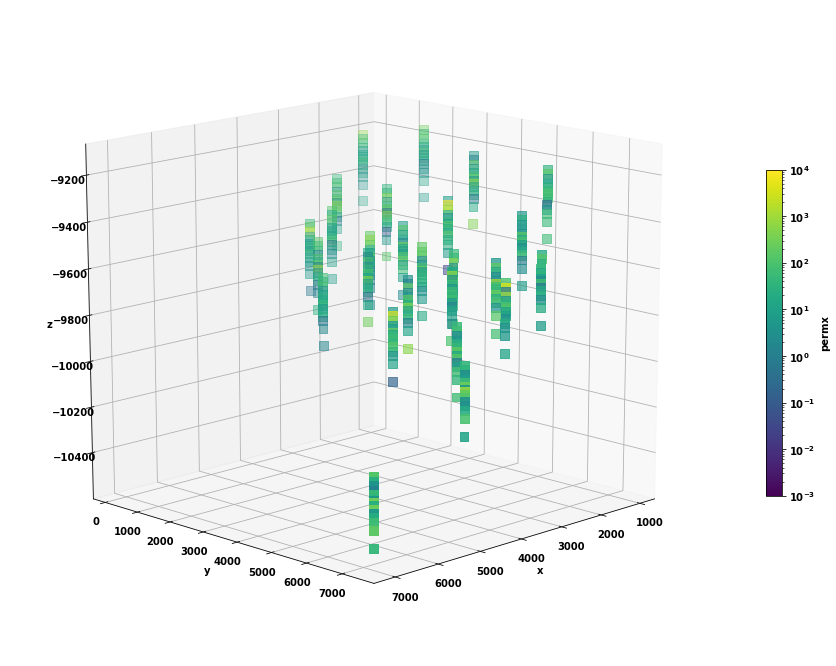

In [12]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter([x[0] for x in X], 
               [x[1] for x in X], 
               [-x[2] for x in X], 
               c=y, marker='s', s=80, 
               norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e4))
ax.set_xlabel('x', weight='bold')
ax.set_ylabel('y', weight='bold')
ax.set_zlabel('z', weight='bold')
ax.view_init(15, 45)
cb = fig.colorbar(p, shrink=0.5)
cb.set_label('permx', weight='bold')
fig.savefig(os.path.join(cwd, 'fig3.png'), dpi=600)

## **Gaussian Process Regression**

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(np.array(y).reshape(-1, 1))
kernel = RBF([5.e-1, 5.e-3, 5.e-3], (1.e-3, 1.e0))
gpr = GaussianProcessRegressor(kernel=kernel, 
                               alpha=0.75,
                               n_restarts_optimizer=10,
                               normalize_y=False,
                               random_state=12345)
y_scaled = y_scaled.flatten()
gpr.fit(X_scaled, y_scaled)
pred, sigma = gpr.predict(X_scaled, return_std=True)
pred = y_scaler.inverse_transform(pred.reshape(1, -1))
print(gpr.score(X_scaled, y_scaled))

0.7085866664527192


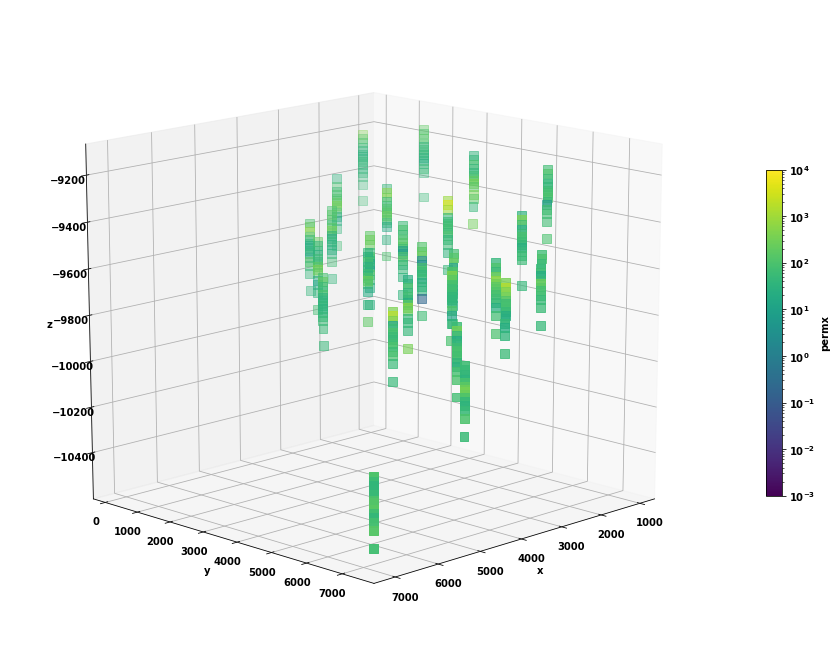

In [14]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter([x[0] for x in X], 
               [x[1] for x in X], 
               [-x[2] for x in X], 
               c=pred.flatten(), marker='s', s=80, 
               norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e4))
ax.set_xlabel('x', weight='bold')
ax.set_ylabel('y', weight='bold')
ax.set_zlabel('z', weight='bold')
ax.view_init(15, 45)
cb = fig.colorbar(p, shrink=0.5)
cb.set_label('permx', weight='bold')
fig.savefig(os.path.join(cwd, 'fig4.png'), dpi=600)

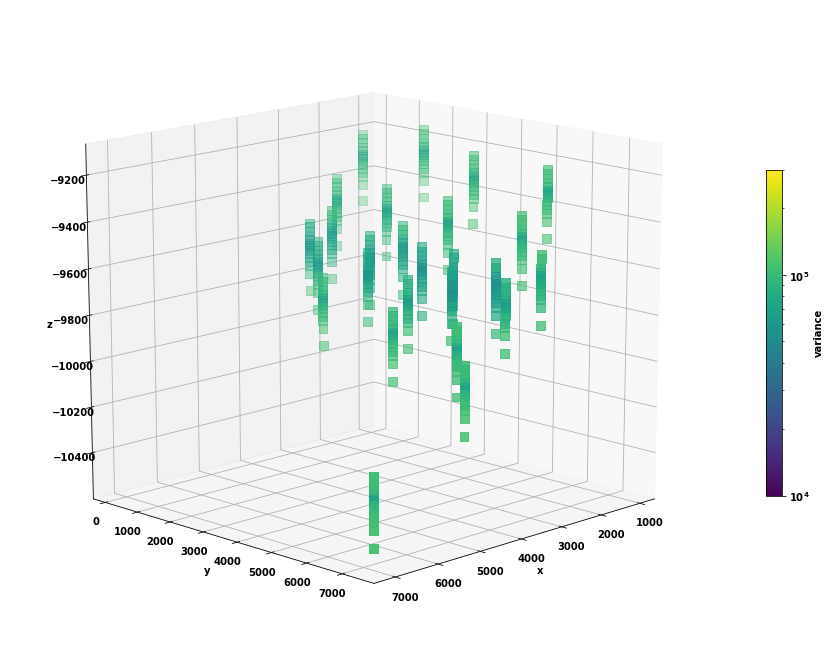

In [15]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter([x[0] for x in X], 
               [x[1] for x in X], 
               [-x[2] for x in X], 
               c=sigma*sigma*var_y, marker='s', s=80, 
               norm=matplotlib.colors.LogNorm(vmin=1.e4, vmax=3.e5))
ax.set_xlabel('x', weight='bold')
ax.set_ylabel('y', weight='bold')
ax.set_zlabel('z', weight='bold')
ax.view_init(15, 45)
cb = fig.colorbar(p, shrink=0.5)
cb.set_label('variance', weight='bold')
fig.savefig(os.path.join(cwd, 'fig5.png'), dpi=600)

In [16]:
X_all = [[center.x for center in centers.flatten()], 
         [center.y for center in centers.flatten()], 
         [center.z for center in centers.flatten()]]
X_all = np.array(X_all)
X_all = X_all.T
X_all_scaled = x_scaler.transform(X_all)
pred_all, sigma_all = gpr.predict(X_all_scaled, return_std=True)
pred_all = y_scaler.inverse_transform(pred_all.reshape(1, -1))

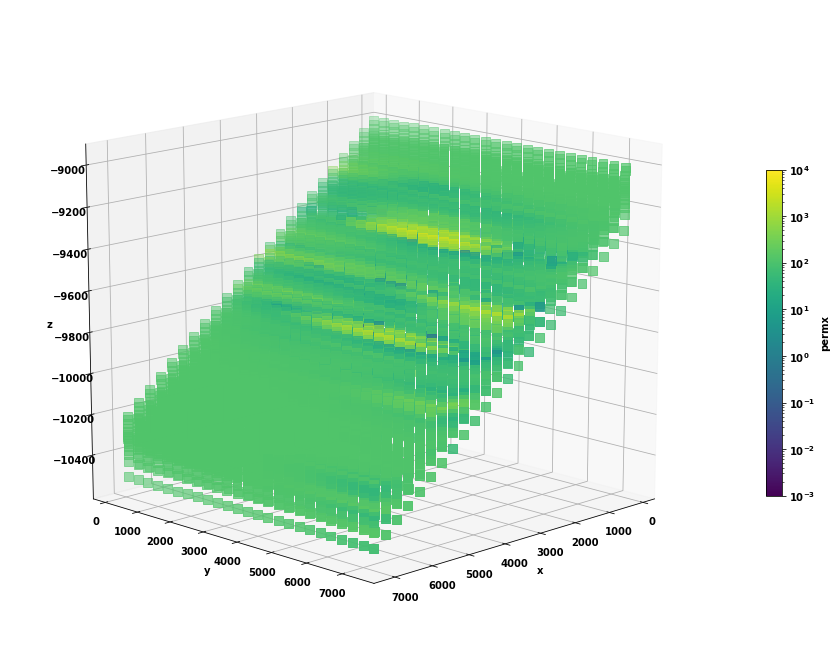

In [17]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter([x[0] for x in X_all], 
               [x[1] for x in X_all], 
               [-x[2] for x in X_all], 
               c=pred_all.flatten(), marker='s', s=80, 
               norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=1.e4))
ax.set_xlabel('x', weight='bold')
ax.set_ylabel('y', weight='bold')
ax.set_zlabel('z', weight='bold')
ax.view_init(15, 45)
cb = fig.colorbar(p, shrink=0.5)
cb.set_label('permx', weight='bold')
fig.savefig(os.path.join(cwd, 'fig6.png'), dpi=600)

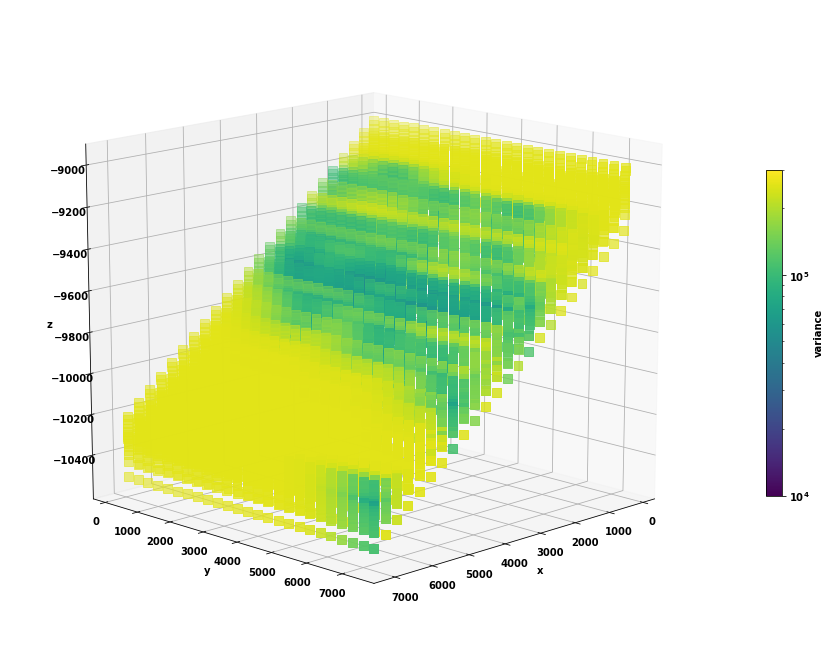

In [18]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter([x[0] for x in X_all], 
               [x[1] for x in X_all], 
               [-x[2] for x in X_all], 
               c=sigma_all.flatten()*sigma_all.flatten()*var_y, marker='s', s=80, 
               norm=matplotlib.colors.LogNorm(vmin=1.e4, vmax=3.e5))
ax.set_xlabel('x', weight='bold')
ax.set_ylabel('y', weight='bold')
ax.set_zlabel('z', weight='bold')
ax.view_init(15, 45)
cb = fig.colorbar(p, shrink=0.5)
cb.set_label('variance', weight='bold')
fig.savefig(os.path.join(cwd, 'fig7.png'), dpi=600)